In [146]:
import json
import requests
import pandas as pd
from py2neo import authenticate, Graph
import urllib2

import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx



Load Star Tech Episode 4 Interactions Graph from GitHub 

In [3]:

url = "https://raw.githubusercontent.com/manlius/StarWars-social-network/master/networks/starwars-episode-4-interactions-allCharacters.json"
import json

response = urllib2.urlopen(url)
  
graph = json.load(response)


<addinfourl at 4855744920 whose fp = <socket._fileobject object at 0x121636f50>>


Load Nodes into a Node Dataframe

In [131]:
nodes_df = pd.DataFrame(graph["nodes"])
nodes_df.rename(columns={'value': 'id', }, inplace=True)
nodes_df.sort_values(by='id', inplace=True)


#Some Charecters have alias so this removes the aliases
nodes_df = nodes_df[nodes_df.name != 'GREEDO']
nodes_df = nodes_df[nodes_df.name != 'CAMIE']
nodes_df = nodes_df[nodes_df.name != 'MOTTI']
nodes_df = nodes_df[nodes_df.name != 'RED TEN']


nodes_df.head()

,colour,name,id
15,#808080,JABBA,3
16,#808080,DODONNA,4
8,#808080,BERU,6
9,#808080,OWEN,7
21,#808080,GOLD FIVE,9


Load Egdes into a DataFram

In [132]:
edges_df = pd.DataFrame(graph["links"])
edges_df.head()


,source,target,value
0,2,0,17
1,3,0,13
2,10,0,6
3,7,0,5
4,13,0,5


Log on to Neo4J

In [135]:
authenticate("localhost:7474", "neo4j", "graphdb")
graph = Graph()
statement = "CREATE (n:Person { name: {name}, id: {id} })" 
tx = graph.begin()

Load Nodes into Neo4 J

In [136]:
for index, row in nodes_df.iterrows():

    tx.append(statement, {"name": row['name'] , "id": row['id']   })
    tx.process
    
tx.commit()

/Users/rnash/gl/anaconda/envs/gl-env/lib/python2.7/site-packages/ipykernel/__main__.py:3: DeprecationWarning: Transaction.append(...) is deprecated, use Transaction.run(...) instead
  app.launch_new_instance()


![](Neo4J_Nodes.png)

Load Neo4J Edges

In [138]:
statement = "MATCH (a:Person),(b:Person)  WHERE a.id = {to}  AND b.id  = {from} CREATE (a)-[r:interactions{times:{times}}] ->(b)"


tx = graph.begin()
for index, row in edges_df.iterrows():
    tx.append(statement, {"from": row['source'] , "to": row['target'] , "times":row['value'] })
    tx.process()

    
tx.commit()


/Users/rnash/gl/anaconda/envs/gl-env/lib/python2.7/site-packages/ipykernel/__main__.py:6: DeprecationWarning: Transaction.append(...) is deprecated, use Transaction.run(...) instead


![](Neo4J_Graph.png)

Create NetworkX object

In [171]:
g = nx.Graph()
g.clear()

#TO Make things easy, I will join the edges and nodes dataset so that the
#name of the NetworkX node is the character's name
merged_df = pd.merge(edges_df, nodes_df , left_on=['source'] , right_on =['id'] )
merged_df= pd.merge(merged_df, nodes_df , left_on=['target'] , right_on =['id'] )
merged_df.rename(columns={'name_x': 'source_name', }, inplace=True)
merged_df.rename(columns={'name_y': 'target_name', }, inplace=True)
merged_df.head()



,source,target,value,colour_x,source_name,id_x,colour_y,target_name,id_y
0,3,9,3,#808080,JABBA,3,#808080,GOLD FIVE,9
1,3,19,3,#808080,JABBA,3,#808080,BIGGS,19
2,7,19,1,#808080,OWEN,7,#808080,BIGGS,19
3,6,19,3,#808080,BERU,6,#808080,BIGGS,19
4,7,3,17,#808080,OWEN,7,#808080,JABBA,3


In [172]:
#Load edges and weights (number of times charecters interacted) to graph object
for index, row in merged_df.iterrows(): 
    g.add_edge(row['source_name'], row['target_name'], weight = row['value']   )

In [173]:
#Load nodes into graph object
nodes_list = g.nodes() 

diameter = nx.diameter(g)  #Diameter needs to be calculated before adding zero degree nodes

#There are a bunch of charecters who have no interaction in the movie.
#They are loaded last.  They are not in the merged_df
zero_degree_node_list = []

for index, row in nodes_df.iterrows(): 
    if row['name'] not in nodes_list:
        g.add_node(row['name'])
        zero_degree_node_list.append(row['name'])
        

In [164]:
g.edges()

[(u'BERU', u'JABBA'),
 (u'BERU', u'OWEN'),
 (u'BERU', u'BIGGS'),
 (u'WEDGE', u'JABBA'),
 (u'DODONNA', u'OWEN'),
 (u'GOLD LEADER', u'TARKIN'),
 (u'TARKIN', u'JABBA'),
 (u'TARKIN', u'OWEN'),
 (u'OWEN', u'JABBA'),
 (u'OWEN', u'BIGGS'),
 (u'GOLD FIVE', u'JABBA'),
 (u'JABBA', u'BIGGS')]

Calculate the Degree Centrality and graph Diameter

In [165]:

degree = nx.degree_centrality(g)  
for key, value in sorted(degree.iteritems(), key=lambda (k,v): (v,k), reverse = True):
    print "%s: %s" % (key, value)

JABBA: 0.352941176471
OWEN: 0.294117647059
TARKIN: 0.176470588235
BIGGS: 0.176470588235
BERU: 0.176470588235
WEDGE: 0.0588235294118
GOLD LEADER: 0.0588235294118
GOLD FIVE: 0.0588235294118
DODONNA: 0.0588235294118
RED LEADER: 0.0
R2-D2: 0.0
OBI-WAN: 0.0
LUKE: 0.0
LEIA: 0.0
HAN: 0.0
DARTH VADER: 0.0
CHEWBACCA: 0.0
C-3PO: 0.0


In [174]:
diameter

3

In [175]:
%matplotlib inline 

In [176]:
#Code int this cell is based on the following stack Exchange question:
#https://stackoverflow.com/questions/17632151/coloring-networkx-edges-based-on-weight


weights = nx.get_edge_attributes(g, "weight")

jet = cm = plt.get_cmap('OrRd') 
cNorm  = colors.Normalize(vmin=-2, vmax=26)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
colorList = []

for value in weights.values():
    colorVal = scalarMap.to_rgba(value)
    colorList.append(colorVal)

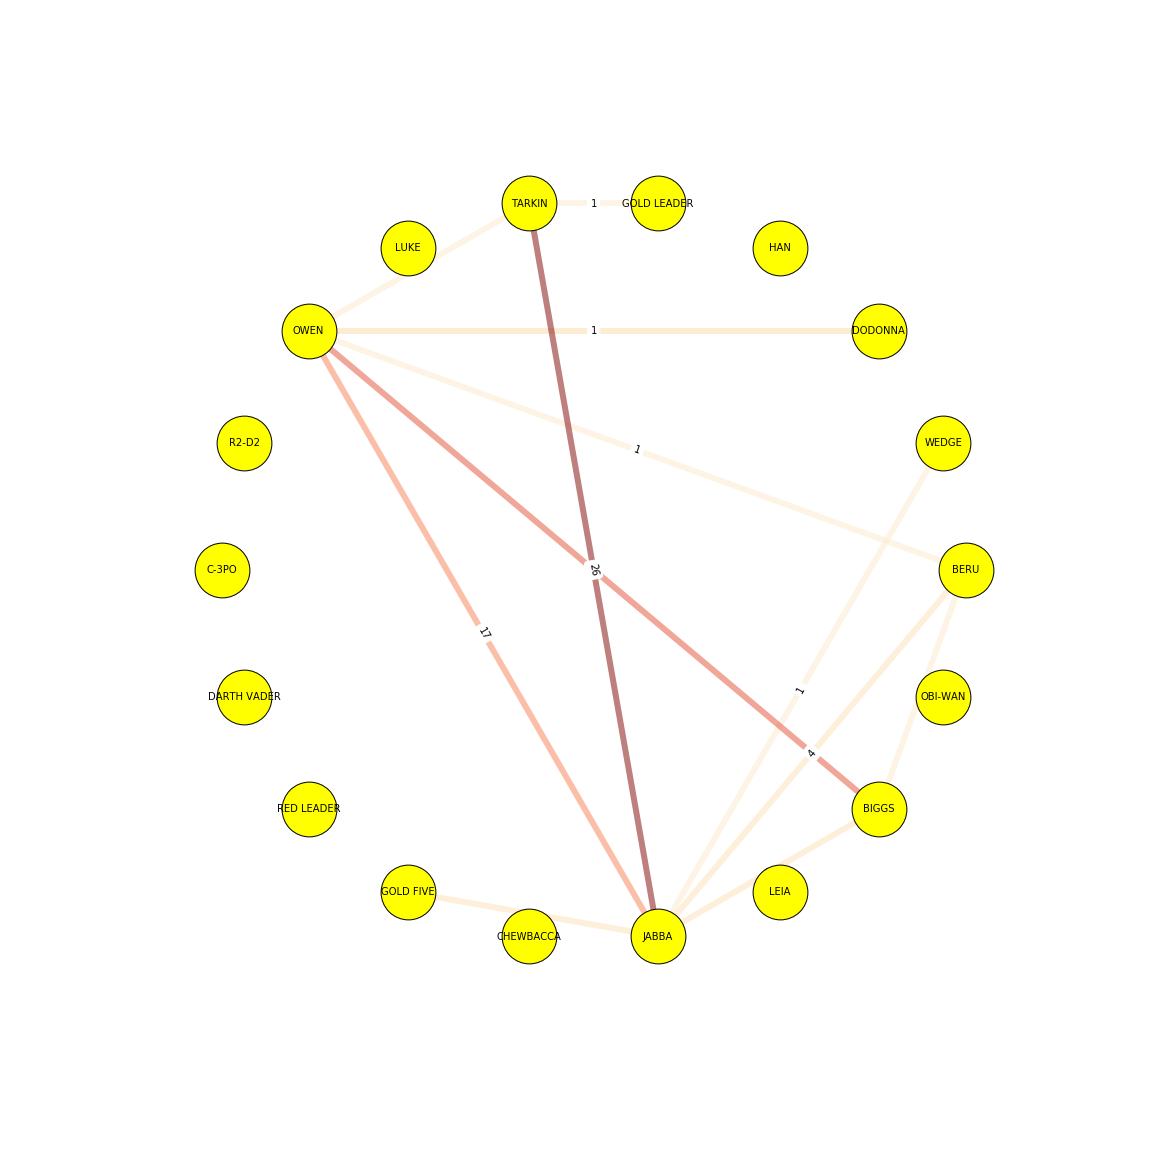

In [189]:
pos = nx.circular_layout(g)

labels = nx.get_edge_attributes(g,'weight')
 

nx.draw_networkx_nodes(g,pos,node_size=3000, node_color='yellow')
nx.draw_networkx_edge_labels(g,pos,edge_labels=labels)


# edges
nx.draw_networkx_edges(g,pos,alpha=0.5,width=6, edge_color=colorList)

nx.draw_networkx_labels(g,pos,font_size=10,font_family='sans-serif', font_color = "black")
plt.axis('off')



plt.rcParams["figure.figsize"] = [20,20]

plt.show()